# Webscraping Craigslist for Housing Listings in the East Bay

### Jennifer Jones

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs4

Populating the interactive namespace from numpy and matplotlib


## Craigslist houses for sale

Look on the Craigslist website, select relevant search criteria, and then take a look at the web address:

Houses for sale in the East Bay:  
[http://sfbay.craigslist.org/search/eby/rea?housing_type=6](http://sfbay.craigslist.org/search/eby/rea?housing_type=6)

Houses for sale in selected neighborhoods in the East Bay:  
[http://sfbay.craigslist.org/search/eby/rea?nh=46&nh=47&nh=48&nh=49&nh=112&nh=54&nh=55&nh=60&nh=62&nh=63&nh=66&housing_type=6](http://sfbay.craigslist.org/search/eby/rea?nh=46&nh=47&nh=48&nh=49&nh=112&nh=54&nh=55&nh=60&nh=62&nh=63&nh=66&housing_type=6) 


## General Procedure

```python

# Get the data using the requests module 
url = 'http://sfbay.craigslist.org/search/eby/rea?housing_type=6'
resp = requests.get(url) 

# BeautifulSoup can quickly parse the text, specify text is html
txt = bs4(resp.text, 'html.parser')

```

## House entries

Looked through output via `print(txt.prettify())` to display the html in a more readable way, to note the structure of housing listings

Saw housing entries contained in `<p class="row">`

`houses = txt.find_all('p', attrs={'class': 'row'})`


## Get data from multiple pages on Craigslist


First page:  
url = 'http://sfbay.craigslist.org/search/eby/rea?housing_type=6'

For multiple pages, the pattern is:  
http://sfbay.craigslist.org/search/eby/rea?s=100&housing_type=6  
http://sfbay.craigslist.org/search/eby/rea?s=200&housing_type=6  
etc.

In [3]:
# Get the data using the requests module 
npgs = np.arange(0,10,1)
npg = 100

base_url = 'http://sfbay.craigslist.org/search/eby/rea?'
urls = [base_url + 'housing_type=6']

for pg in range(len(npgs)):
    url = base_url + 's=' + str(npg) + '&housing_type=6'
    urls.append(url)
    npg += 100

more_reqs = []
for p in range(len(npgs)+1):
    more_req = requests.get(urls[p]) 
    more_reqs.append(more_req)

In [6]:
print(urls)

['http://sfbay.craigslist.org/search/eby/rea?housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=100&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=200&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=300&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=400&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=500&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=600&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=700&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=800&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=900&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=1000&housing_type=6']


In [7]:
# USe BeautifulSoup to parse the text
more_txts = []
for p in range(len(npgs)+1):
    more_txt = bs4(more_reqs[p].text, 'html.parser')
    more_txts.append(more_txt)

# Save the housing entries to a list
more_houses = [more_txts[h].findAll(attrs={'class': "row"}) for h in range(len(more_txts))] 
print(len(more_houses))
print(len(more_houses[0]))

11
100


In [8]:
# Make a list of housing entries from all of the pages of data
npg = len(more_houses)

houses_all = [] 
for n in range(npg):
    houses_all.extend(more_houses[n])
print(len(houses_all))

1100


# Extract and clean data to put in a database

In [9]:
# Define 4 functions for the price, neighborhood, sq footage & # bedrooms, and time
# that can deal with missing values (to prevent errors from showing up when running the code)

# Prices
def find_prices(results):
    prices = []
    for rw in results:
        price = rw.find('span', {'class': 'price'})
        if price is not None:
            price = float(price.text.strip('$'))
        else:
            price = np.nan
        prices.append(price)
    return prices

# Define a function for neighborhood in case a field is missing in 'class': 'pnr'
def find_neighborhood(results):
    neighborhoods = []
    for rw in results:
        split = rw.find('span', {'class': 'pnr'}).text.strip(' (').split(')')
        #split = rw.find(attrs={'class': 'pnr'}).text.strip(' (').split(')')
        if len(split) == 2:
            neighborhood = split[0]
        elif 'pic map' or 'pic' or 'map' in split[0]:
            neighborhood = np.nan
        neighborhoods.append(neighborhood)
    return neighborhoods

# Make a function to deal with size in case #br or ft2 is missing
def find_size_and_brs(results):
    sqft = []
    bedrooms = []
    for rw in results:
        split = rw.find('span', attrs={'class': 'housing'})
        # If the field doesn't exist altogether in a housing entry
        if split is not None:
        #if rw.find('span', {'class': 'housing'}) is not None:
            # Removes leading and trailing spaces and dashes, splits br & ft
            #split = rw.find('span', attrs={'class': 'housing'}).text.strip('/- ').split(' - ')
            split = split.text.strip('/- ').split(' - ')
            if len(split) == 2:
                n_brs = split[0].replace('br', '')
                size = split[1].replace('ft2', '')
            elif 'br' in split[0]: # in case 'size' field is missing
                n_brs = split[0].replace('br', '')
                size = np.nan
            elif 'ft2' in split[0]: # in case 'br' field is missing
                size = split[0].replace('ft2', '')
                n_brs = np.nan
        else:
            size = np.nan
            n_brs = np.nan
        sqft.append(float(size))
        bedrooms.append(float(n_brs))
    return sqft, bedrooms

# Time posted
def find_times(results):
    times = []
    for rw in results:
        time = rw.findAll(attrs={'class': 'pl'})[0].time['datetime']
        if time is not None:
            time# = time
        else:
            time = np.nan
        times.append(time)
    return pd.to_datetime(times)

In [10]:
# Apply functions to data to extract useful information
prices_all = find_prices(houses_all)
neighborhoods_all = find_neighborhood(houses_all) 
sqft_all, bedrooms_all = find_size_and_brs(houses_all)
times_all = find_times(houses_all)

# Check
print(len(prices_all))
#print(len(neighborhoods_all))
#print(len(sqft_all))
#print(len(bedrooms_all))
#print(len(times_all))

1100


## Add data to pandas database

In [47]:
# Make a dataframe to export cleaned data
data = np.array([sqft_all, bedrooms_all, prices_all]).T
print(data.shape)

(1100, 3)


In [48]:
alldata = pd.DataFrame(data = data, columns = ['SqFeet', 'nBedrooms', 'Price'])
alldata.head(4)

,SqFeet,nBedrooms,Price
0,1890,4,539999
1,NaN,4,499950
2,3288,5,609000
3,1200,3,635000


In [49]:
alldata['DatePosted'] = times_all
alldata['Neighborhood'] = neighborhoods_all

In [50]:
alldata.head(4)

,SqFeet,nBedrooms,Price,DatePosted,Neighborhood
0,1890,4,539999,2016-04-08 10:02:00,hayward / castro valley
1,NaN,4,499950,2016-04-08 10:02:00,"hercules, pinole, san pablo, el sob"
2,3288,5,609000,2016-04-08 10:00:00,brentwood / oakley
3,1200,3,635000,2016-04-08 10:00:00,walnut creek


In [52]:
# Check data types
print(alldata.dtypes)
print(type(alldata.DatePosted[0]))
print(type(alldata.SqFeet[0]))
print(type(alldata.nBedrooms[0]))
print(type(alldata.Neighborhood[0]))
print(type(alldata.Price[0]))

SqFeet                 float64
nBedrooms              float64
Price                  float64
DatePosted      datetime64[ns]
Neighborhood            object
dtype: object
<class 'pandas.tslib.Timestamp'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'str'>
<class 'numpy.float64'>


In [17]:
# To change index to/from time field
# alldata.set_index('DatePosted', inplace = True)
# alldata.reset_index(inplace=True)

## Download data to csv file

In [50]:
alldata.to_csv('./webscraping_craigslist.csv', sep=',', na_rep=np.nan, header=True, index=False)


## Data for Berkeley

In [51]:
# Get houses listed in Berkeley
print(len(alldata[alldata['Neighborhood'] == 'berkeley']))
alldata[alldata['Neighborhood'] == 'berkeley']

11


,Price,SqFeet,nBedrooms,DatePosted,Neighborhood
113,849000,1438,3,2016-04-07 09:44:00,berkeley
292,1175000,2192,4,2016-04-06 13:53:00,berkeley
392,1358888,3921,5,2016-04-06 07:18:00,berkeley
415,1565000,3507,5,2016-04-06 06:49:00,berkeley
597,600000,NaN,NaN,2016-04-04 19:56:00,berkeley
655,725000,NaN,2,2016-04-04 12:51:00,berkeley
704,780000,4200,4,2016-04-04 08:12:00,berkeley
824,929000,NaN,3,2016-04-02 09:36:00,berkeley
883,545000,NaN,2,2016-04-01 16:59:00,berkeley
887,1325000,NaN,3,2016-04-01 16:47:00,berkeley


In [52]:
# Home prices in Berkeley (or the baseline)

# Choose a baseline, based on proximity to current location
# 'berkeley', 'berkeley north / hills', 'albany / el cerrito'
neighborhood_name = 'berkeley'

print('The average home price in %s is: $' %neighborhood_name, '{0:8,.0f}'.format(alldata.groupby('Neighborhood').mean().Price.ix[neighborhood_name]), '\n')
print('The most expensive home price in %s is:  $' %neighborhood_name, '{0:8,.0f}'.format(alldata.groupby('Neighborhood').max().Price.ix[neighborhood_name]), '\n')
print('The least expensive home price in %s is: $' %neighborhood_name, '{0:9,.0f}'.format(alldata.groupby('Neighborhood').min().Price.ix[neighborhood_name]), '\n')

The average home price in berkeley is: $  936,444 

The most expensive home price in berkeley is:  $ 1,565,000 

The least expensive home price in berkeley is: $   449,000 



## Scatter plots

In [20]:
# Plot house prices in the East Bay

def scatterplot(X, Y, labels, xmax): # =X.max()): # labels=[]
    
    # Set up the figure
    fig = plt.figure(figsize=(15,8)) # width, height

    fntsz=20
    titlefntsz=25
    lablsz=20
    mrkrsz=8
    matplotlib.rc('xtick', labelsize = lablsz); matplotlib.rc('ytick', labelsize = lablsz)

    # Plot a scatter plot
    ax = fig.add_subplot(111) # row column position 
    ax.plot(X,Y,'bo')

    # Grid
    ax.grid(b = True, which='major', axis='y') # which='major','both'; options/kwargs: color='r', linestyle='-', linewidth=2)

    # Format x axis
    #ax.set_xticks(range(0,len(X))); 
    ax.set_xlabel(labels[0], fontsize = titlefntsz)
    #ax.set_xticklabels(X.index, rotation='vertical') # 90, 45, 'vertical'
    ax.set_xlim(0,xmax)

    # Format y axis
    #minor_yticks  = np.arange(0, 1600000, 100000)
    #ax.set_yticks(minor_yticks, minor = True) 
    ax.set_ylabel(labels[1], fontsize = titlefntsz)
    
    # Set Title
    ax.set_title('$\mathrm{Average \; Home \; Prices \; in \; the \; East \; Bay \; (Source: Craigslist)}$', fontsize = titlefntsz)
    #fig.suptitle('Home Prices in the East Bay (Source: Craigslist)')
    
    # Save figure
    #plt.savefig("home_prices.pdf",bbox_inches='tight')

    # Return plot object
    return fig, ax


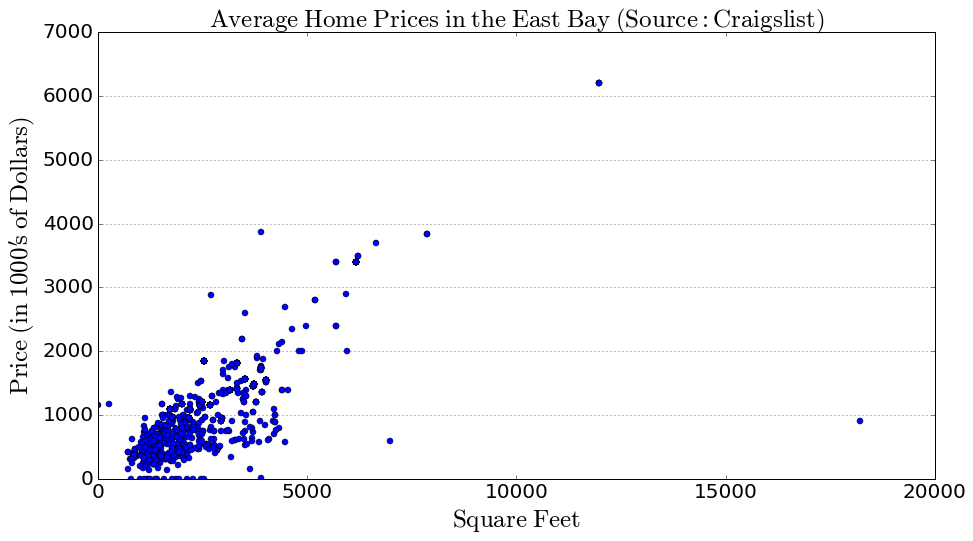

In [22]:
X = alldata.SqFeet
Y = alldata.Price/1000 # in 1000's of Dollars
labels = ['$\mathrm{Square \; Feet}$', '$\mathrm{Price \; (in \; 1000\'s \; of \; Dollars)}$']
ax = scatterplot(X,Y,labels,20000)

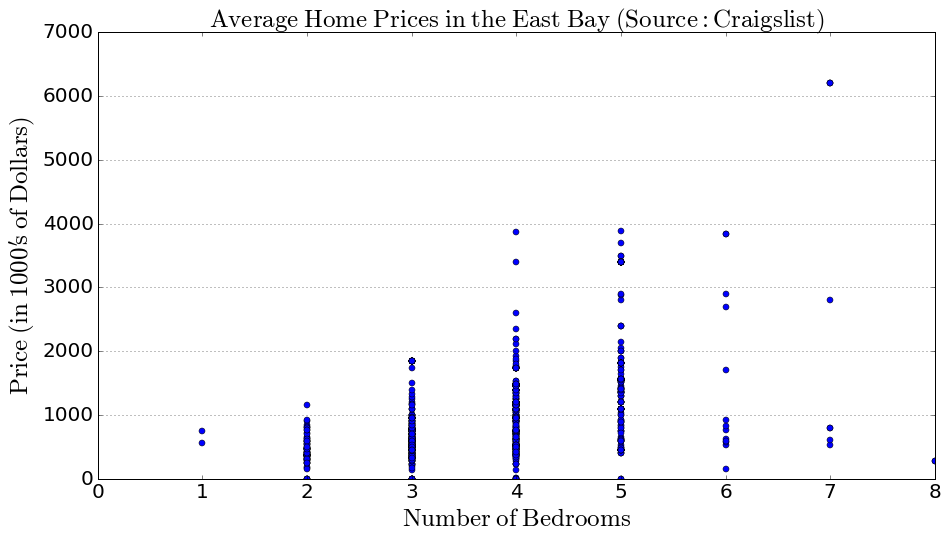

In [24]:
X = alldata.nBedrooms
Y = alldata.Price/1000 # in 1000's of Dollars
labels = ['$\mathrm{Number \; of \; Bedrooms}$', '$\mathrm{Price \; (in \; 1000\'s \; of \; Dollars)}$']
ax = scatterplot(X,Y,labels,X.max())

## Price

In [54]:
# How many houses for sale are under $700k?
price_baseline = 700000
print(alldata[(alldata.Price < price_baseline)].count())

# Return entries for houses under $700k
# alldata[(alldata.Price < price_baseline)]
# In which neighborhoods are these houses located?
set(alldata[(alldata.Price < price_baseline)].Neighborhood)


SqFeet          367
nBedrooms       421
Price           439
DatePosted      439
Neighborhood    432
dtype: int64


{'El Dorado Hills',
 nan,
 'richmond / point / annex',
 'Glorieta, NM',
 'hercules, pinole, san pablo, el sob',
 'Sonora',
 'Discovery Bay',
 'Lower Laurel District',
 '2664 Tronero Way Rancho Cordova CA',
 'albany / el cerrito',
 'oakland downtown',
 'LAS VEGAS',
 'san leandro',
 'Hesperian Gardens',
 'DAVIS',
 'pittsburg / antioch',
 'Clio/Graeagle',
 'Manteca, CA',
 'fremont / union city / newark',
 'walnut creek',
 '5448 Bloom Dr. Marysville CA',
 'brentwood / oakley',
 'oakland west',
 'vallejo / benicia',
 'berkeley north / hills',
 'oakland north / temescal',
 'oakland hills / mills',
 'Elk Grove',
 'Fernley',
 'ELK GROVE',
 'berkeley',
 'oakland lake merritt / grand',
 'sacramento',
 '8954 N. Camden Dr. Elk Grove CA',
 'San Pedro, Belize',
 'South Lake Tahoe',
 'OAKLAND',
 'Oakland',
 'concord / pleasant hill / martinez',
 'Soda Springs, CA',
 'alameda',
 'Somerset, CA',
 'dublin / pleasanton / livermore',
 'Rio Vista',
 'Mariposa',
 'Vallejo Hercules Oakland',
 'hayward / cast

In [72]:
# Would automate this later, just do "quick and dirty" solution for now, to take a fast look
# Neighborhoods to plot
neighborhoodsplt = ['El Dorado Hills',
 'richmond / point / annex',
 'hercules, pinole, san pablo, el sob',
 'albany / el cerrito',
 'oakland downtown',
 'san leandro',
 'pittsburg / antioch',
 'fremont / union city / newark',
 'walnut creek',
 'brentwood / oakley',
 'oakland west',
 'vallejo / benicia',
 'berkeley north / hills',
 'oakland north / temescal',
 'oakland hills / mills',
 'berkeley',
 'oakland lake merritt / grand',
 'sacramento',
 'Oakland',
 'concord / pleasant hill / martinez',
 'alameda',
 'dublin / pleasanton / livermore',
 'hayward / castro valley',
 'Tracy, CA',
 'Oakland Berkeley San Francisco',
 'danville / san ramon',
 'oakland rockridge / claremont',
 'Eastmont',
 'Stockton',
 'Folsom',
 'Tracy',
 'Brentwood',
 'Twain Harte, CA',
 'oakland east',
 'fairfield / vacaville',
 'Pinole, Hercules, Richmond, San Francisc']

In [74]:
#neighborhoodsplt = set(alldata[(alldata.Price < price_baseline)].Neighborhood.sort_values(ascending=True, inplace=True))

## Group results by neighborhood and plot

In [59]:
by_neighborhood = alldata.groupby('Neighborhood').Price.mean()
#by_neighborhood

In [78]:
#alldata.groupby('Neighborhood').Price.mean().ix[neighborhoodsplt]

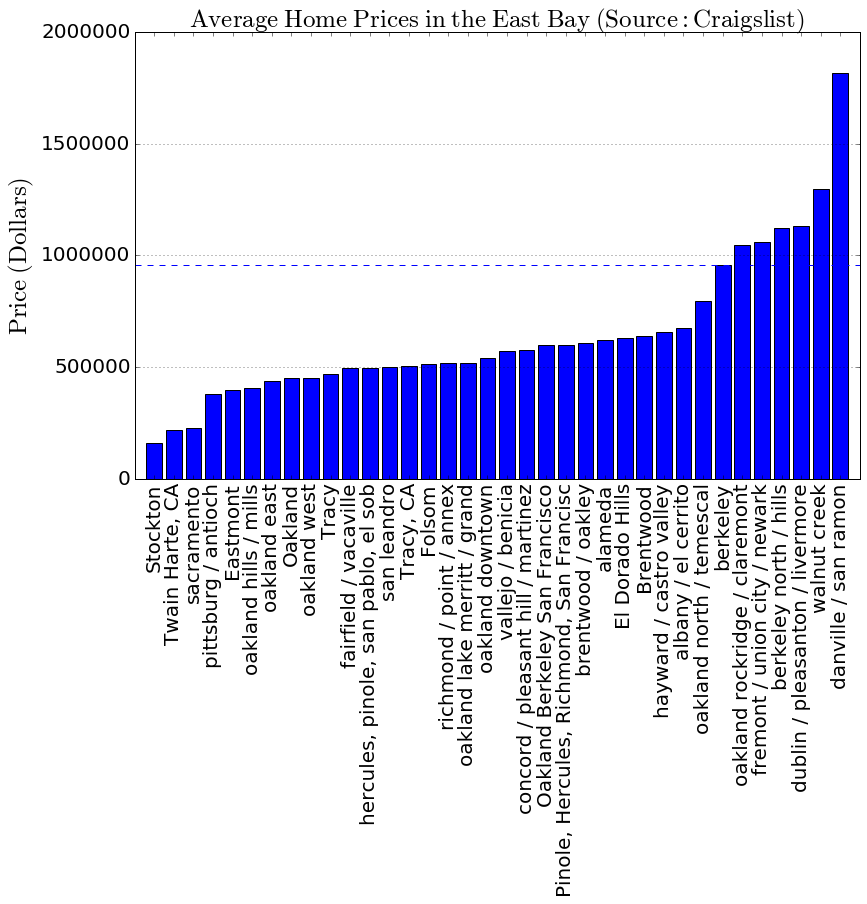

In [79]:
# Home prices in the East Bay

# Group the results by neighborhood, and then take the average home price in each neighborhood
by_neighborhood = alldata.groupby('Neighborhood').Price.mean().ix[neighborhoodsplt]
by_neighborhood_sort_price = by_neighborhood.sort_values(ascending = True) # uncomment
by_neighborhood_sort_price.index # a list of the neighborhoods sorted by price

# Plot average home price for each neighborhood in the East Bay
fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(13.0)

fntsz=20
titlefntsz=25
lablsz=20
mrkrsz=8

matplotlib.rc('xtick', labelsize = lablsz); matplotlib.rc('ytick', labelsize = lablsz)

ax = fig.add_subplot(111) # row column position 

# Plot a bar chart
ax.bar(range(len(by_neighborhood_sort_price.index)), by_neighborhood_sort_price, align='center')

# Add a horizontal line for Berkeley's average home price, corresponds with Berkeley bar
ax.axhline(y=by_neighborhood.ix['berkeley'], linestyle='--')

# Add a grid
ax.grid(b = True, which='major', axis='y') # which='major','both'; options/kwargs: color='r', linestyle='-', linewidth=2)

# Format x axis
ax.set_xticks(range(0,len(by_neighborhood))); 
ax.set_xticklabels(by_neighborhood_sort_price.index, rotation='vertical') # 90, 45, 'vertical'
ax.set_xlim(-1, len(by_neighborhood_sort_price.index))

# Format y axis
ax.set_ylabel('$\mathrm{Price \; (Dollars)}$', fontsize = titlefntsz) # in Hundreds of Thousands of Dollars

# Set figure title
ax.set_title('$\mathrm{Average \; Home \; Prices \; in \; the \; East \; Bay \; (Source: Craigslist)}$', fontsize = titlefntsz)

# Save figure
#plt.savefig("home_prices.pdf",bbox_inches='tight')
